# Sentiments

In [1]:
import pandas as pd
from tqdm import tqdm # Fortschrittsanzeige für pandas
tqdm.pandas() 

### Import der Daten
Legt die Dateien, die in dem Slack-Channel gepostet wurden, unter `data` ab.

In [2]:
tweet_csv = '../data/copbird_table_tweet.csv'
limit = 1000
tweets = pd.read_csv(tweet_csv, nrows=limit)

In [3]:
tweets.head()

id                                         tweet_text  \
0  1321021123463663616  @mahanna196 Da die Stadt keine Ausnahme für Ra...   
1  1321023114071969792  #Zeugengesucht\nDie Hintergründe zu dem Tötung...   
2  1321025127388188673  RT @bka: EUROPE´S MOST WANTED – Sexualstraftät...   
3  1321028108665950208  @StrupeitVolker Wir verstehen nicht so recht w...   
4  1321029199998656513  Wir unterstützen das @bka bei der #Öffentlichk...   

            created_at             user_id  like_count  retweet_count  \
0  2020-10-27 09:29:13  778895426007203840         2.0            1.0   
1  2020-10-27 09:37:08          2397974054        20.0           24.0   
2  2020-10-27 09:45:08          2397974054         NaN            NaN   
3  2020-10-27 09:56:59          2810902381        55.0            2.0   
4  2020-10-27 10:01:19           223758384        16.0            9.0   

   reply_count  quote_count  
0          2.0          0.0  
1          4.0          1.0  
2          NaN          NaN  
3          3.0          0.0  
4          5.0          0.0

## Preprocessing

#### Fehlende Werte

Die folgende Methode zeigt an, in welchen Spalten sich Null-Werte befinden.

In [4]:
def missing_values(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent_1 = df.isnull().sum() / df.isnull().count() * 100
  percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
  missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
  return missing_data

In [5]:
missing_values(tweets)

Total    %
like_count        29  2.9
retweet_count     29  2.9
reply_count       29  2.9
quote_count       29  2.9
id                 0  0.0
tweet_text         0  0.0
created_at         0  0.0
user_id            0  0.0

#### Löschen nicht benötigter Spalten

Vorerst benötigen wir nur die Tweet-ID, den Text, das Erstellungsdatum und die User-ID, deshalb entfernen wir die anderen Spalten.

In [6]:
tweets.drop(columns=['like_count', 'retweet_count', 'reply_count', 'quote_count'])

id                                         tweet_text  \
0    1321021123463663616  @mahanna196 Da die Stadt keine Ausnahme für Ra...   
1    1321023114071969792  #Zeugengesucht\nDie Hintergründe zu dem Tötung...   
2    1321025127388188673  RT @bka: EUROPE´S MOST WANTED – Sexualstraftät...   
3    1321028108665950208  @StrupeitVolker Wir verstehen nicht so recht w...   
4    1321029199998656513  Wir unterstützen das @bka bei der #Öffentlichk...   
..                   ...                                                ...   
995  1322511985125281793  (3/4) Die mit starken Kräften ausgerückte Poli...   
996  1322511987021139968  (4/4) Die beiden in der Wohnung befindlichen P...   
997  1322515912558333952  @Phaidr0s Dies war vorher bei der Versammlungs...   
998  1322516463945715712  Wie fast alles in diesem Jahr ist auch Hallowe...   
999  1322517573016162308  RT @Polizei_MD: Auch wenn Halloween in diesem ...   

              created_at             user_id  
0    2020-10-27 09:29:13  778895426007203840  
1    2020-10-27 09:37:08          2397974054  
2    2020-10-27 09:45:08          2397974054  
3    2020-10-27 09:56:59          2810902381  
4    2020-10-27 10:01:19           223758384  
..                   ...                 ...  
995  2020-10-31 12:13:22          2389342951  
996  2020-10-31 12:13:23          2389342951  
997  2020-10-31 12:28:59  760414297033961474  
998  2020-10-31 12:31:10  819462947982508036  
999  2020-10-31 12:35:35          4803188080  

[1000 rows x 4 columns]

#### Tokenisierung und Bereinigung

Die folgende Methode `clean_text` benutzt die NLP-Bibliothek `spacy`, um aus den Tweets Token (einzelne Wörter) zu generieren, das Lemma eines Wortes zu ermitteln sowie Stoppwörter/Satzzeichen zu entfernen.

In [7]:
import spacy
from string import punctuation

nlp = spacy.load("de_core_news_lg")

def clean_tweet(text):
    doc = nlp(text)
    token_list = []
    
    for token in doc:
        if (token.text not in punctuation) and (token.is_stop is False):
            token_list.append(token.lemma_)
        else:
            pass
    return ' '.join(token_list)

In [8]:
tweets['tweet_text'] = tweets['tweet_text'].progress_apply(lambda text: clean_tweet(text))

100%|██████████| 1000/1000 [00:06<00:00, 156.71it/s]


`encode` kodiert den Tweet in UTF-8 und entfernt Zeichen, die andere Zeichensetzungen eingefügt haben.

In [9]:
import unicodedata

def encode(text):
    return unicodedata.normalize(u'NFKD', text).encode('ascii', 'ignore').decode('utf8')

In [10]:
tweets['tweet_text'] = tweets['tweet_text'].progress_apply(lambda text: encode(text))

100%|██████████| 1000/1000 [00:00<00:00, 268658.98it/s]


Das Resultat sieht so aus: 

In [11]:
tweets.head()

id                                         tweet_text  \
0  1321021123463663616  @mahanna196 Stadt Ausnahme Radfahrer auffuhren...   
1  1321023114071969792  Zeugengesucht \n Hintergrund Totungsdelikt Ges...   
2  1321025127388188673  RT @bka EUROPE   S MOST WANTED  Sexualstraftat...   
3  1321028108665950208          @StrupeitVolker verstehen kennen Glashaus   
4  1321029199998656513  unterstutzen @bka Offentlichkeitsfahndung Tatv...   

            created_at             user_id  like_count  retweet_count  \
0  2020-10-27 09:29:13  778895426007203840         2.0            1.0   
1  2020-10-27 09:37:08          2397974054        20.0           24.0   
2  2020-10-27 09:45:08          2397974054         NaN            NaN   
3  2020-10-27 09:56:59          2810902381        55.0            2.0   
4  2020-10-27 10:01:19           223758384        16.0            9.0   

   reply_count  quote_count  
0          2.0          0.0  
1          4.0          1.0  
2          NaN          NaN  
3          3.0          0.0  
4          5.0          0.0

Damit ist das einfache Preprocessing abgeschlossen. Jetzt können wir mit der Auswertung beginnen.

## Sentiment-Analyse

Für den Abschluss bestimmen wir noch das Sentiment eines jeden Tweets mithilfe eines auf einem deutschen Korpus vortrainierten BERT-Models.

In [12]:
from germansentiment import SentimentModel # siehe https://huggingface.co/oliverguhr/german-sentiment-bert

model = SentimentModel()

In [13]:
tweets['sentiment'] = tweets['tweet_text'].progress_apply(lambda text: model.predict_sentiment([text])[0])

100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s]


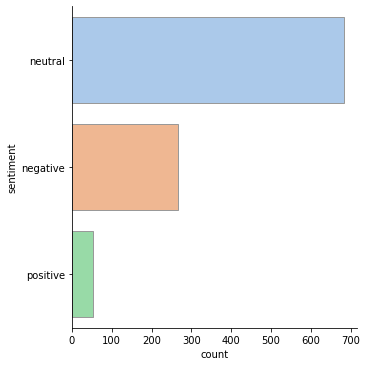

In [14]:
import seaborn as sns

sns.catplot(y="sentiment", kind="count",
            palette="pastel", edgecolor=".6",
            data=tweets)